# **Grad-CAM & DenseNet-121: Explainability Analysis**

## **Imports**

In [ ]:
import os
import random
import json
import pickle
import urllib.request
import requests
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
from scipy.stats import spearmanr
from sklearn.linear_model import SGDClassifier

%matplotlib inline

### **Load pre-trained model** 

In [2]:
densenet121 = models.densenet121(pretrained=True)
densenet121.eval() # set the model to evaluation model
pass

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Load classes** 

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu


### **Preprocessing Pipeline**:

- **Resizing**: The images are resized to $ 256 \times 256 $ pixels.
- **Center Cropping**: The central region of the resized image is cropped to a size of $ 224 \times 224 $ pixels.
- **Tensor Conversion**: The image is converted into a tensor (from a NumPy array).
- **Normalization**: The pixel values are normalized using the following formula:

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

### **Download data**:

In [5]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2025/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/"
dataset = preprocess_image(dir_path)

--2025-02-02 17:49:27--  https://www.lri.fr/~gcharpia/deeppractice/2025/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1614730 (1,5M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1,54M  --.-KB/s    in 0,1s    

2025-02-02 17:49:30 (11,8 MB/s) - ‘TP2_images.zip’ saved [1614730/1614730]

Archive:  TP2_images.zip
   creating: TP2_images/
  inflating: TP2_images/155881293_721e90b57d.jpg  
  inflating: TP2_images/158850087_3251644046.jpg  
  inflating: TP2_images/1624593475_146bf1f7ff.jpg  
  inflating: TP2_images/181748579_01a4611736.jpg  
  inflating: TP2_images/2068921624_ef0986de13.jpg  
  inflating: TP2_images/2637374064_fab14ec0b8.jpg  
  inflating: TP2_images/2749465889_8e62023674.jpg  
  inflating: TP2_images/2936812850_23bf0d1cfd.jpg  
  inflating: TP2_images/3532471222_a6d7e3780e.jpg 

In [6]:
import os

image_folder = "data/TP2_images/TP2_images/"
image_files = os.listdir(image_folder)

print(f"Files in {image_folder}: {image_files}")


Files in data/TP2_images/TP2_images/: ['5233523570_1e0baebe83.jpg', '3633949157_f577605ea9.jpg', '2637374064_fab14ec0b8.jpg', '2749465889_8e62023674.jpg', '4020994958_ee0f171e0d.jpg', '430941039_63cdefff92.jpg', '1624593475_146bf1f7ff.jpg', '9928031928.png', '4872530262_36641b1698.jpg', '3532471222_a6d7e3780e.jpg', '155881293_721e90b57d.jpg', '3894967408_706f2135c6.jpg', '2068921624_ef0986de13.jpg', '490951559_bf34120cd7.jpg', '5635968516_1975a6f8b9.jpg', '158850087_3251644046.jpg', '181748579_01a4611736.jpg', '4178031069_53cc807d15.jpg', '3633913271_ee789a3bc4.jpg', '481635090_85a1c668ed.jpg', '2936812850_23bf0d1cfd.jpg']


## **Grad-CAM Implementation for CNN Interpretability**
This section implements **Grad-CAM (Gradient-weighted Class Activation Mapping)** to generate visual explanations for CNN-based predictions.

### **1. Model Setup & Image Preprocessing**
- Loads a **pretrained DenseNet-121** model.
- Sets the model to **evaluation mode (`eval()`)**.
- Selects the **last convolutional layer** (`model.features.norm5`) as the Grad-CAM target.
- **Preprocessing Pipeline**:
  - Resizes input images to **224×224 pixels**.
  - Converts images to **PyTorch tensors**.
  - Normalizes using **ImageNet mean & std**.

### **2. Grad-CAM Methodology**
Grad-CAM highlights **salient regions** in an image by computing **class-specific activation maps**.

#### **Mathematical Definition**
For a given class **$y$**, Grad-CAM generates a heatmap using the **feature maps** $A_k$ from the last convolutional layer:

$$ L^{\text{Grad-CAM}}_y = \text{ReLU} \left( \sum_k \alpha_k^y A_k \right) $$

where:
- **$A_k$** = Activation map of the **$k^{th}$** feature channel.
- **$\alpha_k^y$** = Importance weight computed as:

$$ \alpha_k^y = \frac{1}{Z} \sum_{i,j} \frac{\partial f_y}{\partial A_k^{(i,j)}} $$

- **$\frac{\partial f_y}{\partial A_k}$** = Gradient of class score w.r.t feature maps.
- **$Z$** = Number of spatial locations in **$A_k$**.
- **ReLU ensures positive contributions** to class activation.

### **3. Grad-CAM Implementation**
The **`GradCAM` class**:
- Registers **hooks** to capture:
  - **Feature maps** (forward pass).
  - **Gradients** (backward pass).
- Computes **Grad-CAM heatmaps** for:
  - **Top-3 predicted classes**.
  - **Least probable class** for comparison.

#### **`generate_cam()`**
- Runs a **forward pass** to get predicted probabilities.
- Computes **class-specific gradients** via **backpropagation**.
- Uses **adaptive average pooling** to generate **importance weights**.
- Combines **feature maps & weights** to compute **Grad-CAM heatmaps**.

### **4. Visualizing Grad-CAM Explanations**
- **`show_grad_cam()`** displays:
  - **Original Image**.
  - **Top-3 class heatmaps** (overlayed on image).
  - **Least probable class heatmap** (in **red** for contrast).

**Example Output:**
- Grad-CAM highlights **relevant object parts** for predicted classes.
- Least probable class heatmap shows **irrelevant feature activations**.

### **5. Running the Grad-CAM Pipeline**
- **Image:** `"data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"`
- **Results:**
  - **Grad-CAM heatmaps** for **top-3 classes**.
  - **Contrastive heatmap** for the **least probable class**.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


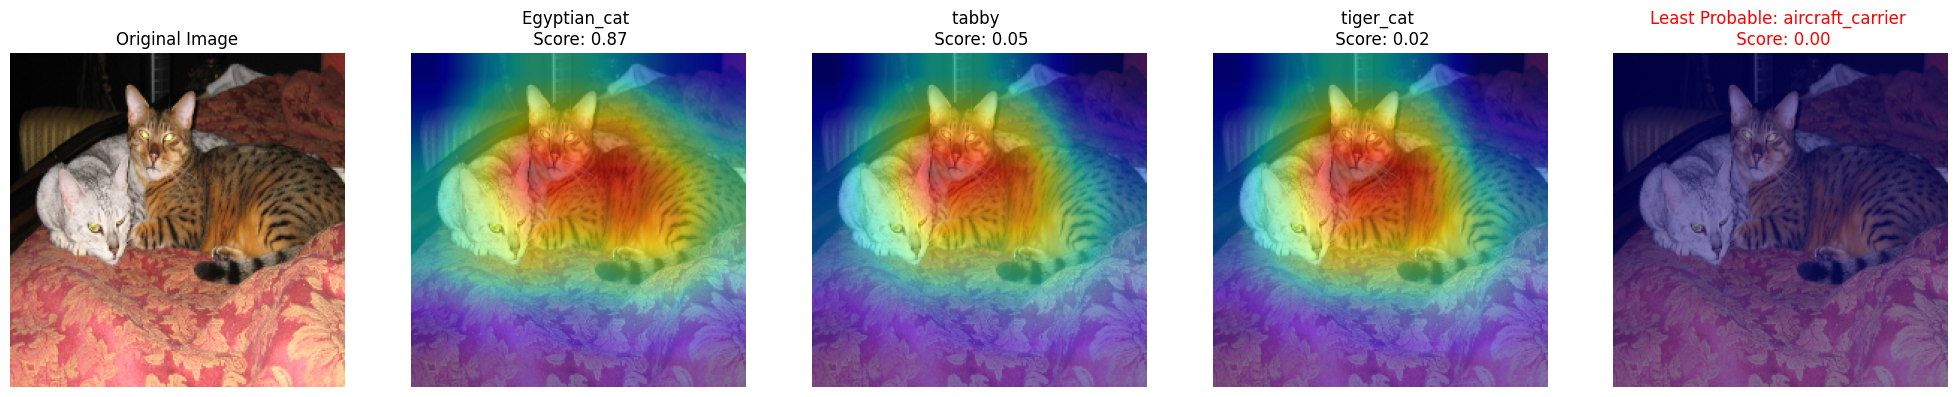

In [ ]:

# Download ImageNet class labels
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
imagenet_classes = requests.get(url).json()
idx_to_class = {int(k): v[1] for k, v in imagenet_classes.items()}

class GradCAM:
    """
    Implements Grad-CAM to generate visual explanations for CNN predictions.
    This class hooks into a convolutional layer of a given model to extract
    feature maps and gradients, computing class-specific heatmaps.

    Args:
        model (nn.Module): Pretrained model .
        conv_layer (nn.Module): The convolutional layer used for Grad-CAM visualization.
    """

    def __init__(self, model, conv_layer):
        self.model = model
        self.feature_map = None
        self.gradient = None
        self.conv_layer = conv_layer

        # Register forward hook to capture feature maps
        self.conv_layer.register_forward_hook(self.forward_hook)

        # Ensure the model is in evaluation mode
        self.model.eval()

    def forward_hook(self, module, input, output):
        """
        Forward hook to capture feature maps from the specified layer.
        """
        if isinstance(output, torch.Tensor):
            self.feature_map = output.clone().detach()  # Store feature maps
            output.register_hook(lambda grad: setattr(self, 'gradient', grad.clone().detach()))  # Capture gradients
        else:
            raise TypeError(f"Expected tensor in forward hook, got {type(output)}")

    def forward_pass(self, image):
        """
        Performs a forward pass through the model and retrieves top-3 predictions.

        Args:
            image (torch.Tensor): Preprocessed image tensor.

        Returns:
            output (torch.Tensor): Model raw class scores
            values (torch.Tensor): Top-3 class probabilities
            indices (torch.Tensor): Indices of the top-3 predicted classes
            least_prob_class (torch.Tensor): Index of the least probable class
            all_classes (torch.Tensor): Top-3 classes + least probable class
            probs (torch.Tensor): Softmax probabilities of all classes.
            feature_map (torch.Tensor): Feature map from the hooked convolutional layer.
        """
        output = self.model(image).squeeze()
        probs = F.softmax(output, dim=0)  # Convert to probabilities
        values, indices = torch.topk(probs, k=3)  # Top-3 predictions

        # Identify the least probable class
        least_prob_class = probs.argmin().unsqueeze(0)
        all_classes = torch.cat((indices, least_prob_class), dim=0)  # Include least probable class

        return output, values, indices, least_prob_class, all_classes, probs, self.feature_map

    def generate_cam(self, image):
        """
        Generates Grad-CAM heatmaps for the top-3 predicted classes and the least probable class.

        Args:
            image (torch.Tensor): Input image tensor.

        Returns:
            heatmaps (list of np.array): Grad-CAM heatmaps for visualization.
            indices (torch.Tensor): Indices of the top-3 predicted classes.
            values (torch.Tensor): Probabilities of the top-3 predicted classes.
            least_prob_class (torch.Tensor): Index of the least probable class.
            least_prob_value (float): Probability of the least probable class.
        """
        output, values, indices, least_prob_class, all_classes, probs, feature_map = self.forward_pass(image)
        heatmaps = []

        for label in all_classes:
            self.model.zero_grad()
            one_hot = torch.zeros_like(output)
            one_hot[label] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            gradients = self.gradient.clone().detach()  # Capture gradients
            weights = F.adaptive_avg_pool2d(gradients, (1, 1))  # Compute importance weights

            # Weighted sum of feature maps
            cam = torch.sum(weights.view(-1, 1, 1) * feature_map, dim=1, keepdim=True)

            # Apply ReLU and upscale to match input size
            cam = F.relu(cam.clone().detach())
            cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
            cam = cam.squeeze().cpu().numpy()

            heatmaps.append(cam)

        return heatmaps, indices, values, least_prob_class, probs[least_prob_class].item()

    def show_grad_cam(self, image_tensor, orig_image):
        """
        Displays Grad-CAM heatmaps for the top-3 predicted classes and the least probable class.

        Args:
            image_tensor (torch.Tensor): Preprocessed input image tensor.
            orig_image (np.array): Original image for visualization.
        """
        heatmaps, indices, values, least_prob_class, least_prob_value = self.generate_cam(image_tensor)

        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        # Plot heatmaps for the top-3 predicted classes
        for i in range(3):
            ax[i+1].imshow(orig_image)

            heatmap = heatmaps[i]
            if len(heatmap.shape) > 2:
                heatmap = np.mean(heatmap, axis=0)

            class_name = idx_to_class[indices[i].item()]  # Get class name
            ax[i+1].imshow(heatmap, cmap='jet', alpha=0.5)
            ax[i+1].set_title(f"{class_name} \n Score: {values[i]:.2f}")
            ax[i+1].axis("off")

        # Plot least probable class
        ax[4].imshow(orig_image)

        heatmap = heatmaps[3]
        if len(heatmap.shape) > 2:
            heatmap = np.mean(heatmap, axis=0)

        class_name = idx_to_class[least_prob_class.item()]  # Get class name
        ax[4].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[4].set_title(f"Least Probable: {class_name} \n Score: {least_prob_value:.2f}", color="red")
        ax[4].axis("off")

        plt.show()


# Load DenseNet-121 and modify ReLU to avoid in-place modifications
model = models.densenet121(pretrained=True)
for module in model.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False
model.eval()

# Initialize GradCAM with the last convolutional layer
grad_cam = GradCAM(model, model.features.norm5)


def preprocess_image(image_path):
    """
    Loads and preprocesses an image for DenseNet-121.

    Args:
        image_path (str): Path to the image file.

    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

def show_grad_cam(image_path: str):
    """
    Wrapper function to preprocess image, compute Grad-CAM, and display results.

    Args:
        image_path (str): Path to the input image.
    """
    image_tensor = preprocess_image(image_path)

    # Load original image for visualization
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    orig_image = cv2.resize(orig_image, (224, 224))

    # Run Grad-CAM and display results
    grad_cam.show_grad_cam(image_tensor, orig_image)

show_grad_cam("data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg")

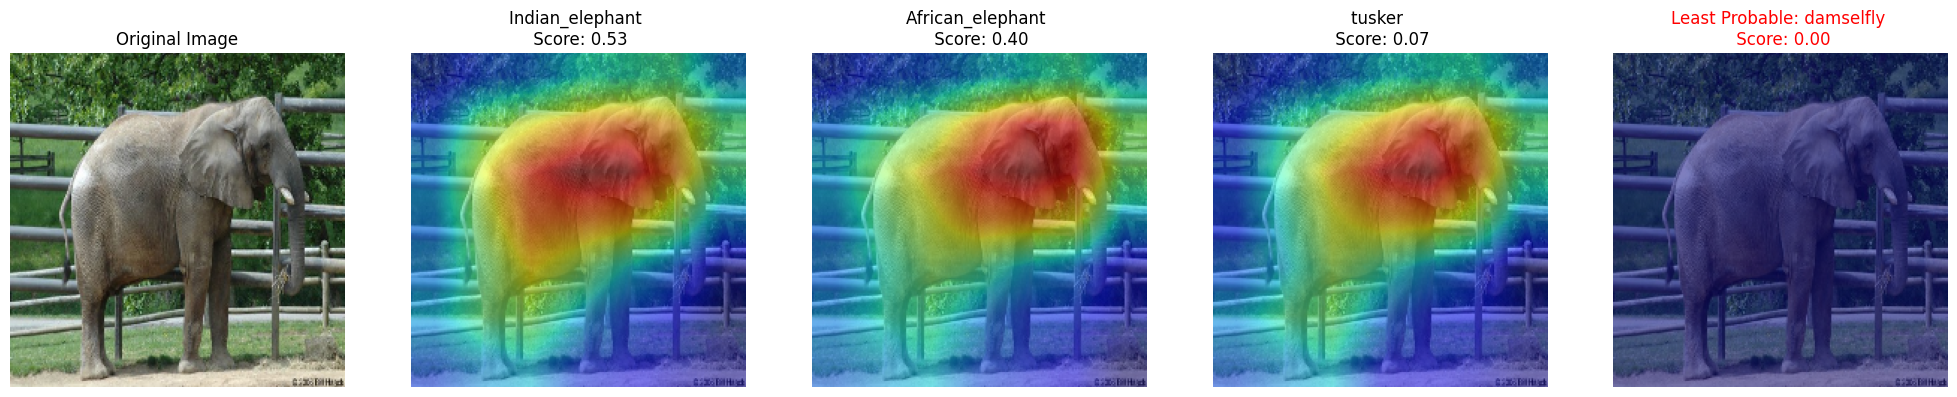

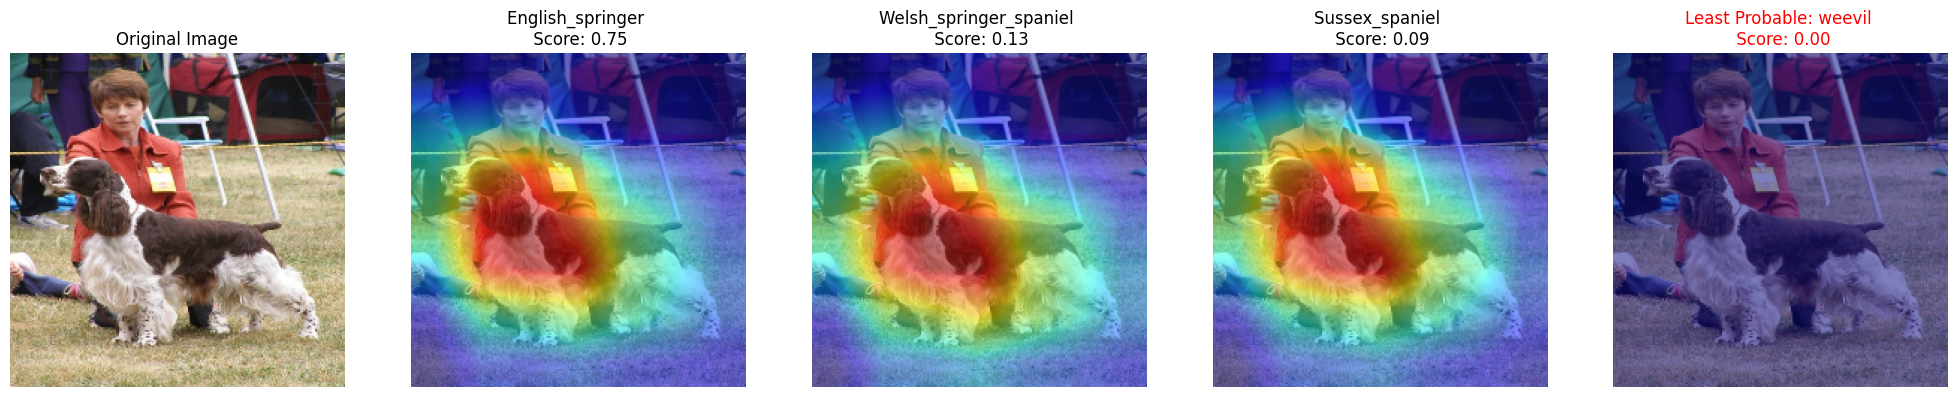

In [8]:
show_grad_cam("data/TP2_images/TP2_images/155881293_721e90b57d.jpg")
show_grad_cam("data/TP2_images/TP2_images/2068921624_ef0986de13.jpg")


## **Grad-CAM Evaluation: Robustness, Faithfulness & Localization**
This section evaluates **Grad-CAM** explanations using multiple interpretability metrics. The evaluation tests the reliability of the heatmaps generated for CNN-based predictions.

### **1. Robustness to Noise**
- **Goal**: Check if Grad-CAM heatmaps remain stable under **small perturbations**.
- **Method**:
  - Gaussian noise $ \mathcal{N}(0, \sigma) $ with $ \sigma = 0.1 $ is added to the image.
  - Spearman correlation is computed between original and perturbed heatmaps:

  $$ \rho = \frac{\sum (R_x - \bar{R_x})(R_y - \bar{R_y})}{\sqrt{\sum (R_x - \bar{R_x})^2 \sum (R_y - \bar{R_y})^2}} $$

  - **Higher correlation** means the heatmap is robust.

### **2. Faithfulness: Deletion & Insertion Tests**
- **Goal**: Check if removing or adding important regions affects model confidence.
- **Method**:
  - **Deletion Test**:
    - Remove top **10% most important pixels** in the heatmap.
    - Measure confidence **drop** in the predicted class.
    - **Larger drop = More faithful heatmap**.

  $$ \text{Faithfulness}_{\text{Deletion}} = \int_0^{10} f(y_{del}(p)) dp $$

  - **Insertion Test**:
    - Start with a **zeroed image** and gradually add **important pixels**.
    - Measure confidence **increase** in the predicted class.
    - **Higher increase = More meaningful attributions**.

  $$ \text{Faithfulness}_{\text{Insertion}} = \int_0^{10} f(y_{ins}(p)) dp $$

### **3. Complexity: Explanation Sparsity**
- **Goal**: Check if the explanation is **focused** rather than spread across the image.
- **Method**:
  - Computes the fraction of pixels with **high attributions**:

  $$ C = \frac{1}{N} \sum_{i,j} \mathbb{1} (H(i,j) > 0.1) $$

  - **Lower values = Simpler, more interpretable heatmaps**.

### **4. Localization Accuracy (IoU Score)**
- **Goal**: Check if the heatmap **overlaps with the expected object region**.
- **Method**:
  - Computes **Intersection-over-Union (IoU)** between **binarized heatmap** and **ground truth mask**.

  $$ \text{IoU} = \frac{| H \cap M |}{| H \cup M |} $$

  where:
  - **$H$** = Heatmap with top **10%** of values.
  - **$M$** = Ground truth object mask.

  - **Higher IoU = More accurate attribution**.

### **5. Randomization Test**
- **Goal**: Check if Grad-CAM heatmaps capture meaningful features **or random noise**.
- **Method**:
  - Replace the pretrained ResNet-50 **with random weights**.
  - Compute **Spearman correlation** between original and randomized heatmaps.
  - **Low correlation = Meaningful attributions**.


In [ ]:

def add_gaussian_noise(image, std=0.1):
    """
    Adds Gaussian noise to an image.

    Args:
        image (torch.Tensor): Input image tensor.
        std (float): Standard deviation of Gaussian noise.

    Returns:
        torch.Tensor: Noisy image tensor.
    """
    noise = torch.randn_like(image) * std
    return torch.clamp(image + noise, 0, 1)


def compute_robustness(grad_cam, image_tensor):
    """
    Measures robustness of Grad-CAM by checking stability under slight perturbations.

    Args:
        grad_cam (GradCAM): Grad-CAM instance.
        image_tensor (torch.Tensor): Input image tensor.

    Returns:
        float: Robustness score (Spearman correlation between original and perturbed heatmaps).
    """
    orig_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)

    perturbed_image = add_gaussian_noise(image_tensor)
    perturbed_heatmap, _, _, _, _ = grad_cam.generate_cam(perturbed_image)

    spearman_corrs = []
    for orig, perturbed in zip(orig_heatmap, perturbed_heatmap):
        orig_flat = orig.flatten()
        perturbed_flat = perturbed.flatten()

        # Check if heatmap is constant
        if np.std(orig_flat) == 0 or np.std(perturbed_flat) == 0:
            spearman_corrs.append(0)  # No valid correlation possible
        else:
            spearman_corr, _ = spearmanr(orig_flat, perturbed_flat)
            spearman_corrs.append(spearman_corr)

    return np.mean(spearman_corrs)


def compute_faithfulness(grad_cam, image_tensor, model):
    """
    Measures faithfulness by progressively removing important pixels and observing model performance.

    Args:
        grad_cam (GradCAM): Grad-CAM instance.
        image_tensor (torch.Tensor): Input image tensor.
        model (torch.nn.Module): CNN model.

    Returns:
        tuple: Insertion and deletion scores.
    """
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = torch.tensor(heatmap[0])  # Use first class heatmap

    # Sort pixels by importance
    importance_order = torch.argsort(heatmap.flatten(), descending=True)
    image_flat = image_tensor.clone().detach().flatten()

    deletion_scores = []
    insertion_scores = []

    # Gradually remove most important features
    modified_image = image_tensor.clone().detach()
    for i in range(1, len(importance_order), len(importance_order) // 10):
        modified_image = modified_image.view(-1)
        modified_image[importance_order[:i]] = 0
        modified_image = modified_image.view(image_tensor.shape)

        output = model(modified_image).softmax(dim=1)
        deletion_scores.append(output.max().item())

    # Gradually add most important features back
    modified_image = torch.zeros_like(image_tensor)
    for i in range(1, len(importance_order), len(importance_order) // 10):
        modified_image = modified_image.view(-1)
        modified_image[importance_order[:i]] = image_flat[importance_order[:i]]
        modified_image = modified_image.view(image_tensor.shape)

        output = model(modified_image).softmax(dim=1)
        insertion_scores.append(output.max().item())

    return np.trapz(deletion_scores), np.trapz(insertion_scores)


def compute_complexity(grad_cam, image_tensor):
    """
    Computes complexity of an explanation by measuring sparsity in the heatmap.

    Args:
        grad_cam (GradCAM): Grad-CAM instance.
        image_tensor (torch.Tensor): Input image tensor.

    Returns:
        float: Complexity score (lower values indicate concise explanations).
    """
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = torch.tensor(heatmap[0])
    return (heatmap > 0.1).float().mean().item()


def compute_localization(grad_cam, image_tensor, ground_truth_mask):
    """
    Evaluates how well Grad-CAM localizes features relevant to the task.

    Args:
        grad_cam (GradCAM): Grad-CAM instance.
        image_tensor (torch.Tensor): Input image tensor.
        ground_truth_mask (np.array): Binary mask (1=important, 0=background).

    Returns:
        float: Localization score (IoU between heatmap and mask).
    """
    heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)
    heatmap = heatmap[0]

    # Resize ground truth mask
    if ground_truth_mask.shape != (224, 224):
        ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    # Ensure the mask is non-empty
    if ground_truth_mask.max() == 0:
        print("⚠ Warning: The ground truth mask is completely empty.")
        return 0.0

    # Normalize and resize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = cv2.resize(heatmap, (224, 224))

    # Binarize heatmap
    threshold = np.percentile(heatmap, 90)
    heatmap_binary = (heatmap > threshold).astype(np.uint8)

    # Compute IoU
    intersection = np.logical_and(heatmap_binary, ground_truth_mask).sum()
    union = np.logical_or(heatmap_binary, ground_truth_mask).sum()

    return intersection / union if union > 0 else 0.0


def compute_randomization(grad_cam, image_tensor, randomized_model):
    """
    Tests explanation stability by randomizing model weights.

    Returns:
        float: Randomization score.
    """
    orig_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)

    # Randomize model weights
    for layer in randomized_model.parameters():
        if layer.requires_grad:
            torch.nn.init.normal_(layer, mean=0, std=1)

    rand_heatmap, _, _, _, _ = grad_cam.generate_cam(image_tensor)

    spearman_corrs = []
    for orig, rand in zip(orig_heatmap, rand_heatmap):
        orig_flat = orig.flatten()
        rand_flat = rand.flatten()

        if np.std(orig_flat) == 0 or np.std(rand_flat) == 0:
            spearman_corrs.append(0)
        else:
            spearman_corr, _ = spearmanr(orig_flat, rand_flat)
            spearman_corrs.append(spearman_corr)

    return np.mean(spearman_corrs)


def evaluate_grad_cam(image_path, model, grad_cam, ground_truth_mask):
    """
    Evaluates Grad-CAM using multiple metrics.

    Returns:
        dict: Evaluation scores.
    """
    image_tensor = preprocess_image(image_path)

    return {
        "Robustness": compute_robustness(grad_cam, image_tensor),
        "Faithfulness (Deletion)": compute_faithfulness(grad_cam, image_tensor, model)[0],
        "Faithfulness (Insertion)": compute_faithfulness(grad_cam, image_tensor, model)[1],
        "Complexity": compute_complexity(grad_cam, image_tensor),
        "Localization": compute_localization(grad_cam, image_tensor, ground_truth_mask),
        "Randomization": compute_randomization(grad_cam, image_tensor, models.densenet121(weights=None))
    }

ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[70:150, 70:150] = 1  # Smaller region for better accuracy

# Example usage
image_path = "data/TP2_images/TP2_images/155881293_721e90b57d.jpg"
scores = evaluate_grad_cam(image_path, model, grad_cam, ground_truth_mask)

print("Grad-CAM Evaluation Scores:", scores)



/var/folders/xv/76zyg58x4_96rxvg794ms7rr0000gn/T/ipykernel_94658/1829415701.py:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(deletion_scores), np.trapz(insertion_scores)


Grad-CAM Evaluation Scores: {'Robustness': np.float64(0.5926430425537111), 'Faithfulness (Deletion)': np.float64(4.554146885871887), 'Faithfulness (Insertion)': np.float64(7.778953668661416), 'Complexity': 0.96484375, 'Localization': np.float64(0.38299418604651164), 'Randomization': np.float64(0.75)}


## **Grad-CAM Evaluation Metrics**

This section describes the evaluation metrics used to assess the quality of Grad-CAM explanations. The following metrics are computed using a given Grad-CAM heatmap, a ground truth binary mask, and model confidence scores.

### **Evaluation Metrics**

- **IoU (Intersection over Union)**: Measures the overlap between the binarized Grad-CAM heatmap and the ground truth mask.
  
  $$ \text{IoU} = \frac{|H \cap M|}{|H \cup M|} $$

- **Precision**: Indicates how many of the heatmap’s highlighted regions match the ground truth.

  $$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $$

- **Recall**: Measures how much of the ground truth mask is captured by the Grad-CAM heatmap.

  $$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $$

- **Pointing Game Score**: Checks whether the pixel with the highest activation in the heatmap falls within the ground truth region.
  
  $$ \text{Pointing Game} = 
  \begin{cases} 
  1 & \text{if max activation point in mask} \\
  0 & \text{otherwise}
  \end{cases} $$

- **Average Drop (%)**: Measures how much confidence drops when masking out the most important regions. A higher drop indicates more faithful explanations.
  
  $$ \text{Average Drop} = \frac{(P_{\text{orig}} - P_{\text{masked}})}{P_{\text{orig}}} \times 100 $$

- **Confidence Increase (%)**: Measures how much confidence increases when adding back important regions to a blank image.

  $$ \text{Confidence Increase} = \frac{(P_{\text{masked}} - P_{\text{orig}})}{P_{\text{orig}}} \times 100 $$






Evaluation Metrics: {'IoU': np.float64(0.551451800232288), 'Precision': np.float64(0.5680784876764776), 'Recall': np.float64(0.9496), 'Pointing Game': 1, 'Average Drop (%)': 99.99999671724741, 'Increase in Confidence (%)': -99.99999671724741}


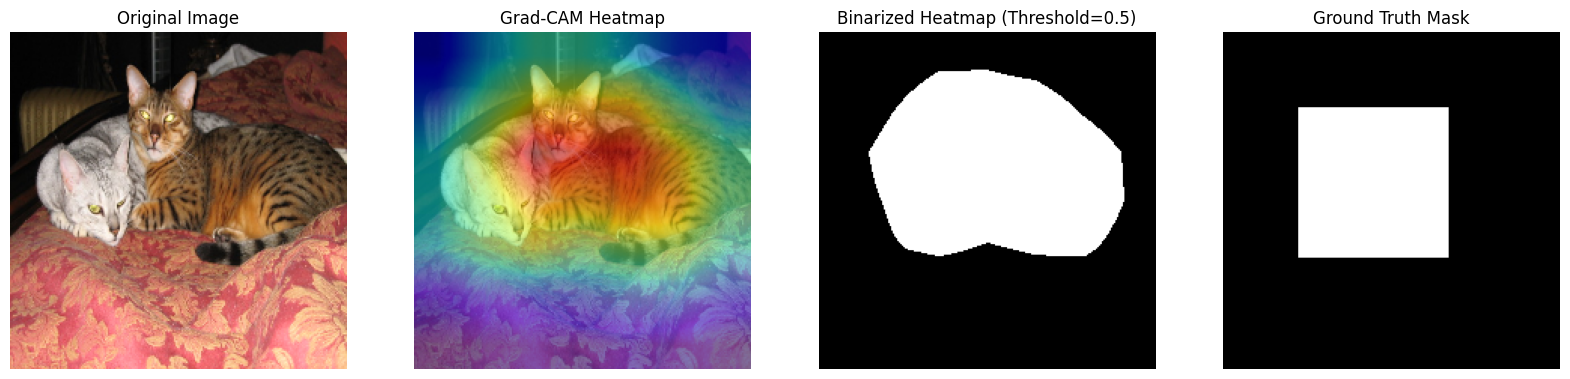

In [ ]:


def compute_metrics(grad_cam_heatmap, ground_truth_mask, original_probs, masked_probs, threshold=0.5):
    """
    Computes evaluation metrics for Grad-CAM explanations.

    Args:
        grad_cam_heatmap (np.array): The Grad-CAM heatmap (activation scores).
        ground_truth_mask (np.array): The ground truth binary mask (1 = important, 0 = background).
        original_probs (float): Model probability before masking.
        masked_probs (float): Model probability after masking.
        threshold (float): Threshold to binarize Grad-CAM heatmap.

    Returns:
        dict: Dictionary with computed IoU, Precision, Recall, and Pointing Game Score.
    """

    # Normalize Grad-CAM heatmap
    grad_cam_heatmap = (grad_cam_heatmap - grad_cam_heatmap.min()) / (grad_cam_heatmap.max() - grad_cam_heatmap.min())

    # Convert heatmap to binary mask using threshold
    binarized_heatmap = (grad_cam_heatmap >= threshold).astype(np.uint8)

    # Compute True Positives, False Positives, False Negatives
    intersection = np.logical_and(binarized_heatmap, ground_truth_mask).sum()
    union = np.logical_or(binarized_heatmap, ground_truth_mask).sum()
    false_positives = (binarized_heatmap == 1).sum() - intersection
    false_negatives = (ground_truth_mask == 1).sum() - intersection

    # Compute Metrics
    iou = intersection / union if union != 0 else 0
    precision = intersection / (intersection + false_positives) if (intersection + false_positives) > 0 else float('nan')
    recall = intersection / (intersection + false_negatives) if (intersection + false_negatives) > 0 else float('nan')

    # Pointing Game: Does the max activation fall inside the ground truth region?
    max_activation_point = np.unravel_index(np.argmax(grad_cam_heatmap), grad_cam_heatmap.shape)
    pointing_game_score = int(ground_truth_mask[max_activation_point] == 1)

    # Compute Average Drop and Confidence Increase
    avg_drop = ((original_probs - masked_probs) / original_probs) * 100 if original_probs > 0 else 0
    confidence_increase = ((masked_probs - original_probs) / original_probs) * 100 if original_probs > 0 else 0

    return {
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "Pointing Game": pointing_game_score,
        "Average Drop (%)": avg_drop,
        "Increase in Confidence (%)": confidence_increase
    }



def visualize_evaluation(image, grad_cam_heatmap, ground_truth_mask, threshold=0.5):
    """
    Displays the original image, Grad-CAM heatmap, binarized heatmap, and ground truth mask.

    Args:
        image (np.array): The original input image.
        grad_cam_heatmap (np.array): The computed Grad-CAM heatmap.
        ground_truth_mask (np.array): The binary ground truth mask.
        threshold (float): Threshold to binarize Grad-CAM heatmap.
    """

    # Normalize and threshold heatmap
    grad_cam_heatmap = (grad_cam_heatmap - grad_cam_heatmap.min()) / (grad_cam_heatmap.max() - grad_cam_heatmap.min())
    binarized_heatmap = (grad_cam_heatmap >= threshold).astype(np.uint8)

    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Grad-CAM Heatmap
    axes[1].imshow(image)
    axes[1].imshow(grad_cam_heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    # Binarized Heatmap
    axes[2].imshow(binarized_heatmap, cmap="gray")
    axes[2].set_title(f"Binarized Heatmap (Threshold={threshold})")
    axes[2].axis("off")

    # Ground Truth Mask
    axes[3].imshow(ground_truth_mask, cmap="gray")
    axes[3].set_title("Ground Truth Mask")
    axes[3].axis("off")

    plt.show()

# Load your real image
image_path = "data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"

# Load and preprocess image
image_tensor = preprocess_image(image_path)

# Load original image for visualization
orig_image = cv2.imread(image_path)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
orig_image = cv2.resize(orig_image, (224, 224))

# Generate Grad-CAM heatmap
heatmaps, indices, values, least_prob_class, least_prob_value = grad_cam.generate_cam(image_tensor)

# Use heatmap of the most probable class (index 0)
grad_cam_heatmap = heatmaps[0]

# Example Ground Truth Mask (Modify as needed)
ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[50:150, 50:150] = 1  # Example: A square mask

# Compute evaluation metrics
metrics = compute_metrics(grad_cam_heatmap, ground_truth_mask, values[0].item(), least_prob_value)
print("Evaluation Metrics:", metrics)

# Visualize results
visualize_evaluation(orig_image, grad_cam_heatmap, ground_truth_mask)


## **Concept-Based Model Interpretability Using TCAV**

This section outlines a pipeline for computing TCAV (Testing with Concept Activation Vectors) scores. It includes steps for preprocessing images, extracting feature activations, training Concept Activation Vectors (CAVs), and evaluating their influence on model predictions.

### **1. Preprocessing and Loading Images**

- **Preprocessing Pipeline**: All images are resized to $ 224 \times 224 $, normalized to have mean $[0.485, 0.456, 0.406]$ and standard deviation $[0.229, 0.224, 0.225]$, and converted to PyTorch tensors.
- **Image Loading Function**:  
  - Converts images to RGB.
  - Applies the preprocessing pipeline.
  - Returns a stack of image tensors for further processing.
  
**Example Folders:**
- **Stripes**: Images showcasing striped patterns.
- **Fur Texture**: Images representing fur-like textures.
- **Face Shape**: Images illustrating different face shapes.
- **Random Baseline**: A control group of randomly chosen images.


### **2. Model and Feature Extraction**

- **Pretrained Model**: DenseNet-121 initialized with ImageNet weights.
- **Target Layer**: The final convolutional layer of the DenseNet model.
- **Activation Extraction**:  
  - A forward hook captures the activations from the target layer.
  - Activations are flattened for each image to form feature vectors.
  


### **3. Normalizing Activations**

- **Purpose**: Normalize activations to zero mean and unit variance for consistent CAV training.
- **Method**: Subtract the mean and divide by the standard deviation across all activations.


### **4. Training Concept Activation Vectors (CAVs)**

- **CAV Training**:  
  - Combines concept activations (e.g., stripes, fur) with random activations.
  - Labels concept activations as 1 and random activations as 0.
  - Uses logistic regression with strong regularization to learn a directional vector that represents the concept.
  
**Example Concepts:**
- **Stripes**: Represents striped patterns.
- **Fur Texture**: Represents textures similar to animal fur.
- **Face Shape**: Represents geometric features of a face.
  
**Regularization**:  
- A lower $ C$ parameter in logistic regression enforces stronger regularization, reducing overfitting and improving generalization.



### **5. Computing TCAV Scores**

- **Directional Derivative**: Measures how much model predictions align with a concept.
- **TCAV Score**:  
  - The fraction of images where the directional derivative is positive.
  - A higher score indicates that the model heavily relies on the given concept for its predictions.
  
**Example Results:**
- **TCAV for Stripes Concept**: High score indicates the model relies on stripe-like patterns.
- **TCAV for Fur Texture Concept**: Reveals if fur-like textures contribute to predictions.
- **TCAV for Face Shape Concept**: Evaluates the importance of facial geometry.

---

### **6. Random Baseline Visualization**

- **Purpose**: Show random images used as a control group for training CAVs.
- **Method**:  
  - De-normalize the images (revert preprocessing).
  - Display a sample of the random baseline images to confirm variety.
  
**Visualization**:  
- Side-by-side display of random images used in the baseline group.



🔍 Stripes Activation Shape: torch.Size([86, 50176])
🔍 Fur Activation Shape: torch.Size([107, 50176])
🔍 Face Shape Activation Shape: torch.Size([143, 50176])
🔍 Random Activation Shape: torch.Size([93, 50176])
📊 Mean Activation (Concept): -4.526218844169705e-10 ± 0.9941532611846924
📊 Mean Activation (Random): 0.0 ± 0.9945939779281616
📊 Mean Activation (Concept): 3.637895540364866e-10 ± 0.9953010678291321
📊 Mean Activation (Random): 0.0 ± 0.9945939779281616
📊 Mean Activation (Concept): -2.6369972871975733e-10 ± 0.9964813590049744
📊 Mean Activation (Random): 0.0 ± 0.9945939779281616
Mean DD: 0.0828, Std DD: 0.0000
Mean DD: 0.0353, Std DD: 0.0000
Mean DD: 0.0067, Std DD: 0.0000
✅ TCAV Score for 'Stripes' Concept: 1.0000
✅ TCAV Score for 'Fur Texture' Concept: 1.0000
✅ TCAV Score for 'Face Shape' Concept: 1.0000


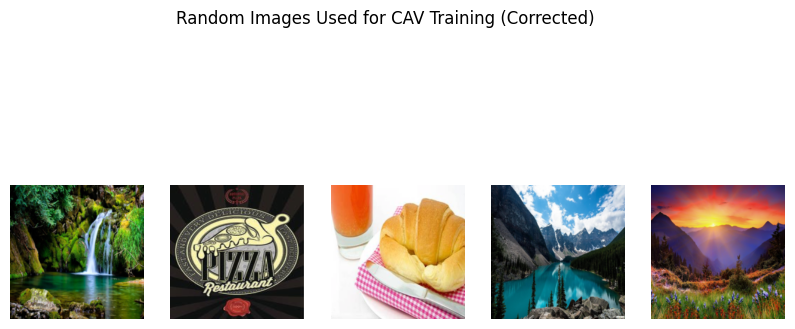

In [ ]:


# Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load images and apply transformations
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid images
            try:
                image = Image.open(img_path).convert("RGB")  # Convert to RGB
                image = transform(image)
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return torch.stack(images) if images else None

# Load Concept Images
stripes_images = load_images_from_folder("data/concepts/stripes")
fur_images = load_images_from_folder("data/concepts/fur_texture")
face_shape_images = load_images_from_folder("data/concepts/face_shape")
random_images = load_images_from_folder("data/concepts/random_baseline")  # Random Control Group

# Ensure valid datasets were loaded
assert stripes_images is not None, "Stripes images not loaded!"
assert fur_images is not None, " Fur images not loaded!"
assert face_shape_images is not None, "Face shape images not loaded!"
assert random_images is not None, " Random baseline images not loaded!"


# Load DenseNet-121 model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.eval()
target_layer = model.features[-1]  # Use the last convolutional layer


# Function to extract activations from a target layer
def extract_activations(model, layer, images):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.clone().detach())

    hook = layer.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        model(images)

    hook.remove()
    return activations[0].view(images.shape[0], -1)  # Flatten activations

# Extract activations
stripes_activations = extract_activations(model, target_layer, stripes_images)
fur_activations = extract_activations(model, target_layer, fur_images)
face_shape_activations = extract_activations(model, target_layer, face_shape_images)
random_activations = extract_activations(model, target_layer, random_images)


def normalize_activations(activations):
    return (activations - activations.mean(dim=0)) / (activations.std(dim=0) + 1e-8)

stripes_activations = normalize_activations(stripes_activations)
fur_activations = normalize_activations(fur_activations)
face_shape_activations = normalize_activations(face_shape_activations)
random_activations = normalize_activations(random_activations)


def train_cav(concept_activations, random_activations):
    X = torch.cat([concept_activations, random_activations]).numpy()
    Y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

    # Ensure activations are different
    print(f"Mean Activation (Concept): {concept_activations.mean().item()} ± {concept_activations.std().item()}")
    print(f"Mean Activation (Random): {random_activations.mean().item()} ± {random_activations.std().item()}")

    # Stronger regularization
    # cav = SGDClassifier(alpha=10.0, max_iter=1000, loss="log_loss", penalty="l2")
    from sklearn.linear_model import LogisticRegression
    # cav = LogisticRegression(max_iter=2000)
    cav = LogisticRegression(C=0.1, max_iter=5000, solver="lbfgs")  # Lower C = stronger regularization

    cav.fit(X, Y)

    return cav.coef_[0]  # Concept Activation Vector (CAV)

print(f"Stripes Activation Shape: {stripes_activations.shape}")
print(f"Fur Activation Shape: {fur_activations.shape}")
print(f"Face Shape Activation Shape: {face_shape_activations.shape}")
print(f"Random Activation Shape: {random_activations.shape}")

# Train CAVs for different concepts
cav_stripes = train_cav(stripes_activations, random_activations)
cav_fur = train_cav(fur_activations, random_activations)
cav_face_shape = train_cav(face_shape_activations, random_activations)

def compute_tcav_score(image_activations, cav_vector):
    if isinstance(image_activations, torch.Tensor):
        image_activations = image_activations.detach().cpu().numpy()

    cav_vector = np.array(cav_vector)

    # Normalize correctly (ensure no zero vectors)
    image_activations_norm = np.linalg.norm(image_activations, axis=1, keepdims=True) + 1e-8
    cav_norm = np.linalg.norm(cav_vector) + 1e-8

    image_activations /= image_activations_norm
    cav_vector /= cav_norm

    # Compute directional derivative
    directional_derivative = np.dot(image_activations, cav_vector)

    # 🔍 Debug: Check directional derivative distribution
    print(f"Mean DD: {directional_derivative.mean():.4f}, Std DD: {directional_derivative.std():.4f}")

    # Compute TCAV Score
    return float(np.mean(directional_derivative > 0))

# Load Image for TCAV
image_path = "data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
image_activations = extract_activations(model, target_layer, image_tensor)

# Compute TCAV Scores
tcav_stripes = compute_tcav_score(image_activations, cav_stripes)
tcav_fur = compute_tcav_score(image_activations, cav_fur)
tcav_face_shape = compute_tcav_score(image_activations, cav_face_shape)

print(f"TCAV Score for 'Stripes' Concept: {tcav_stripes:.4f}")
print(f"TCAV Score for 'Fur Texture' Concept: {tcav_fur:.4f}")
print(f"TCAV Score for 'Face Shape' Concept: {tcav_face_shape:.4f}")



def denormalize(tensor):
    tensor = tensor.clone().detach().cpu().permute(1, 2, 0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    return torch.clamp(tensor, 0, 1).numpy()

random_images_list = [denormalize(img) for img in random_images]

plt.figure(figsize=(10, 5))
random_sample = random.sample(random_images_list, min(5, len(random_images_list)))
for i, img in enumerate(random_sample):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Random Images Used for CAV Training (Corrected)")
plt.show()
